# Get light-curves from ZTF and PS1 for SNAD catalog

This notebook demonstrates how to get epoch photometry for a custom pointing catalog,
in this case, the [SNAD catalog](https://snad.space/catalog/).
We will get the SNAD catalog as a pandas dataframe, cross-match it with [PS1 DR2 object (OTMO) "detection"](https://outerspace.stsci.edu/display/PANSTARRS/) catalogs and [ZTF DR16 Zubercal](http://nesssi.cacr.caltech.edu/ZTF/Web/Zuber.html) catalog.

### Install and import required packages

In [1]:
# Install lsdb and matplotlib
%pip install --quiet lsdb matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsdb import read_hats, from_dataframe
from upath import UPath

### Define paths to PS1 DR2 catalogs

We access all the data through the web, so we don't need to download it in advance.
However, we are going much more data than we're actually going to use, so it will take some time.

In [3]:
# Define paths to PS1 DR2 catalogs
PS1_PATH = UPath("s3://stpubdata/panstarrs/ps1/public/hats/", anon=True)
PS1_OBJECT = PS1_PATH / "otmo"
PS1_DETECTION = PS1_PATH / "detection"

# Define paths to ZTF DR16 Zubercal catalog
ZUBERCAL_PATH = "https://data.lsdb.io/hats/ztf_dr16/zubercal/"

### Download and convert SNAD catalog to Hats format, in memory

[SNAD catalog](https://snad.space/catalog/) is just ~100 rows, we download it through Pandas and convert to LSDB's Catalog object with `lsdb.from_dataframe`.

In [4]:
# Load SNAD catalog, remove rows with missing values and rename columns to more friendly names
snad_df = (
    pd.read_csv(
        "https://snad.space/catalog/snad_catalog.csv",
        dtype_backend="pyarrow",
    )
    .rename(columns={"R.A.": "ra", "Dec.": "dec"})
    .dropna()
)
display(snad_df)

# Convert to LSDB's Catalog object
snad_catalog = from_dataframe(
    snad_df,
    # Optimize partition size
    drop_empty_siblings=True,
    # Keep partitions small
    lowest_order=5,
)
display(snad_catalog)

,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments
0,SNAD101,247.45543,24.77282,633207400004730,2018-04-08 09:45:49,21.11,0.27,0.36,20.84,0.06,AT 2018lwh,PSN,ZTF18abqkqdm
1,SNAD102,245.05375,28.3822,633216300024691,2018-03-21 11:08:19,21.18,0.28,0.39,20.26,0.07,AT 2018lwi,PSN,ZTF18abdgwos
3,SNAD104,218.9162,46.38441,758205400019523,2018-06-24 07:23:27,20.1,0.14,0.16,20.89,0.1,AT 2018lwk,PSN,ZTF18aawqbuc
7,SNAD108,257.84004,48.21127,762209400037712,2018-04-16 10:34:47,21.23,0.28,0.38,20.99,0.06,AT 2018lwo,PSN,ZTF18abauopo
10,SNAD111,263.42634,52.62203,796201100002136,2018-06-21 07:59:02,21.32,0.28,0.39,21.72,0.15,AT 2018lwr,PSN,ZTF18abdldos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,SNAD251,206.83488,46.85701,757206100012904,2018-05-12 05:54:12,20.81,0.27,0.36,20.55*,0.02,AT 2018moe,PSN,ZTF18aautehk
152,SNAD254,245.16939,29.81557,633216100000357,2018-05-24 08:39:53,20.49,0.2,0.25,19.68,0.04,AT 2018moh,PSN,ZTF18aazziao
154,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,0.18,0.21,21.55*,0.03,AT 2018moj,AGN,ZTF18aashxde
155,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,0.28,0.37,20.56,0.04,AT 2018mok,PSN,ZTF18abhxidx


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix
npartitions=104,,,,,,,,,,,,,,,,
"Order: 7, Pixel: 3996",string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 7, Pixel: 22298",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 130876",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 8184",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Load PS1 catalog structure and metadata

`lsdb.read_hipscat` doesn't load the data immediately, it just reads the metadata and structure of the catalog.
Here we use it to load PS1 DR2 object and detection catalogs, selecting only a few columns to speed up the pipeline.

In [5]:
# Load PS1 catalogs metadata
ps1_object = read_hats(
    PS1_OBJECT,
    columns=[
        "objID",  # PS1 ID
        "raMean",
        "decMean",  # coordinates to use for cross-matching
        "nStackDetections",  # some other data to use
    ],
)
display(ps1_object)

ps1_detection = read_hats(
    PS1_DETECTION,
    columns=[
        "objID",  # PS1 object ID
        "detectID",  # PS1 detection ID
        # not really going to use it, but we can alternatively directly cross-match with detection table
        "ra",
        "dec",
        # light-curve stuff
        "obsTime",
        "filterID",
        "psfFlux",
        "psfFluxErr",
    ],
)
display(ps1_detection)

,objID,raMean,decMean,nStackDetections
npartitions=27161,,,,
"Order: 5, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...


,objID,detectID,ra,dec,obsTime,filterID,psfFlux,psfFluxErr
npartitions=83004,,,,,,,,
"Order: 6, Pixel: 0",int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow]
"Order: 6, Pixel: 1",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...,...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...,...,...,...,...


### Load ZTF DR16 Zubercal catalog

Zubercal is a uber-calibrated light-curve catalog for ZTF DR16.
It matches ZTF detections to PS1 objects and provides calibrated magnitudes. 

In [6]:
# Load Zubercal metadata
zubercal = read_hats(
    ZUBERCAL_PATH,
    columns=[
        "objectid",  # matches to PS1 objID
        "mjd",
        "band",
        "mag",
        "magerr",  # integer, units are 1e-4 mag
    ],
)
display(zubercal)

,objectid,mjd,band,mag,magerr
npartitions=70853,,,,,
"Order: 5, Pixel: 0",int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],uint16[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 6, Pixel: 49150",...,...,...,...,...
"Order: 6, Pixel: 49151",...,...,...,...,...


### Plan cross-matching and joining

LSDB doesn't do any work until you call `compute` method, so here we just plan the work.

1. We find PS1 objects that are within 1 arcsec of SNAD objects.
2. Join Zubercal catalog to aggregate light-curves. Each light-curve would be represented by a "nested" dataframe, where each row is a detection.
3. Do the same for PS1 detections.  


In [7]:
# Planning cross-matching with objects, no work happens here
snad_ps1 = snad_catalog.crossmatch(
    ps1_object,
    radius_arcsec=1.0,
    suffixes=["", ""],
)

# Join with Zubercal detections to get one more set of light-curves
snad_ztf_lc = snad_ps1.join_nested(
    zubercal,
    left_on="objID",
    right_on="objectid",
    # light-curve will live in "ztf_lc" column
    nested_column_name="ztf_lc",
    output_catalog_name="snad_ztf_lc",
)

# Join with PS1 detections to get light-curves
snad_ps1_ztf_lc = snad_ztf_lc.join_nested(
    ps1_detection,
    left_on="objID",
    right_on="objID",
    # light-curve will live in "ps1_lc" column
    nested_column_name="ps1_lc",
    output_catalog_name="snad_ps1_ztf_lc",
)

display(snad_ps1_ztf_lc)

/Users/hombit/projects/lincc-frameworks/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/hombit/projects/lincc-frameworks/lsdb/src/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/hombit/projects/lincc-frameworks/lsdb/src/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix,objID,raMean,decMean,nStackDetections,_dist_arcsec,ztf_lc,ps1_lc
npartitions=110,,,,,,,,,,,,,,,,,,,,,,,
"Order: 7, Pixel: 3996",string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],"nested<mjd: [double], band: [string], mag: [fl...","nested<detectID: [int64], ra: [double], dec: [..."
"Order: 7, Pixel: 22298",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 130947",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 130954",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Run the pipeline!

Here we finally run the pipeline and get the light-curves.
This requires Dask client for parallel execution, and you probably want to adjust the parameters to your hardware.
See Dask documentation for details: [Dask deployment](https://docs.dask.org/en/stable/deploying.html), [Dask deployment with Python](https://docs.dask.org/en/stable/deploying-python.html?highlight=LocalCluster#distributed.deploy.local.LocalCluster).

The output `ndf` is a nested dataframe, `NestedFrame` from [nested-pandas](https://nested-pandas.readthedocs.io/en/latest/) package.
We will see later how to access the light-curves from it.


In [8]:
%%time

# It will take a way to fetch all the data from the Internet
with dask.distributed.Client() as client:
    display(client)
    ndf = snad_ps1_ztf_lc.compute()

display(ndf)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51895,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:51909,Total threads: 3
Dashboard: http://127.0.0.1:51912/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:51898,


/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 11.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-03-04 16:10:55,381 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/hombit/.vi

,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,...,Norder,Dir,Npix,objID,raMean,decMean,nStackDetections,_dist_arcsec,ztf_lc,ps1_lc
_healpix_29,,,,,,,,,,,,,,,,,,,,,
70302101074407965,SNAD258,43.61864,35.95618,653113400006264,2018-08-06 11:56:08,19.93,0.12,0.13,20.67*,0.02,...,7,0,3996,151140436186487948,43.618644,35.956121,10,0.211484,mjd band mag magerr 0 ...,detectID ra dec ...
392277456679397513,SNAD242,171.50084,44.9646,753101100007466,2018-06-03 04:41:06,20.97,0.3,0.41,20.03,0.06,...,7,20000,22298,161951715008458066,171.500832,44.964503,10,0.34803,mjd band mag magerr 0 ...,detectID ra dec ...
392922938507087610,SNAD195,173.23891,47.54846,754108100010282,2019-05-14 05:00:23,20.62,0.2,0.25,20.84,0.04,...,7,20000,22335,165051732389348889,173.238928,47.548471,5,0.058477,mjd band mag magerr 0 ...,detectID ra dec ...
446151138901733801,SNAD243,113.9192,31.77959,662105400007673,2018-03-30 05:34:18,20.81,0.28,0.39,19.8,0.07,...,7,20000,25360,146131139191046084,113.919172,31.779571,10,0.110847,mjd band mag magerr 0 ...,detectID ra dec ...
516485618782572321,SNAD183,121.02564,55.26591,783109400002438,2018-10-31 11:16:41,20.39,0.21,0.27,20.49,0.05,...,7,20000,29358,174311210256119671,121.025694,55.265833,10,0.297867,mjd band mag magerr 0 ...,detectID ra dec ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290669782911240776,SNAD206,265.96869,23.83512,635101200003331,2019-06-01 10:34:06,20.78,0.19,0.23,20.47,0.05,...,7,130000,130209,136602659686272754,265.968642,23.835102,5,0.16953,mjd band mag magerr 0 ...,detectID ra dec ...
2292793947685369161,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,0.28,0.37,20.56,0.04,...,7,130000,130330,140692759687248560,275.9687,27.248313,5,0.242748,mjd band mag magerr 0 ...,detectID ra dec ...
2296992969234801244,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,0.18,0.21,21.55*,0.03,...,7,130000,130568,139002635644905861,263.564473,25.837727,5,0.174805,mjd band mag magerr 0 ...,detectID ra dec ...


CPU times: user 2min 45s, sys: 55.8 s, total: 3min 41s
Wall time: 49min 1s


### Plot first five light curves

Here we plot light curves, you can change plot type by setting `MAG_OR_FLUX` to `mag` or `flux`.

`NestedFrame` from `nested-pandas` ([docs](https://nested-pandas.readthedocs.org)) is just a wrapper around pandas `DataFrame`, so all you know about pandas applies here.
Every light-curve is packed into items of `ps1_lc` and `ztf_lc` columns.
When you are getting a single element from a nested dataframe, you get a pandas dataframe!

/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


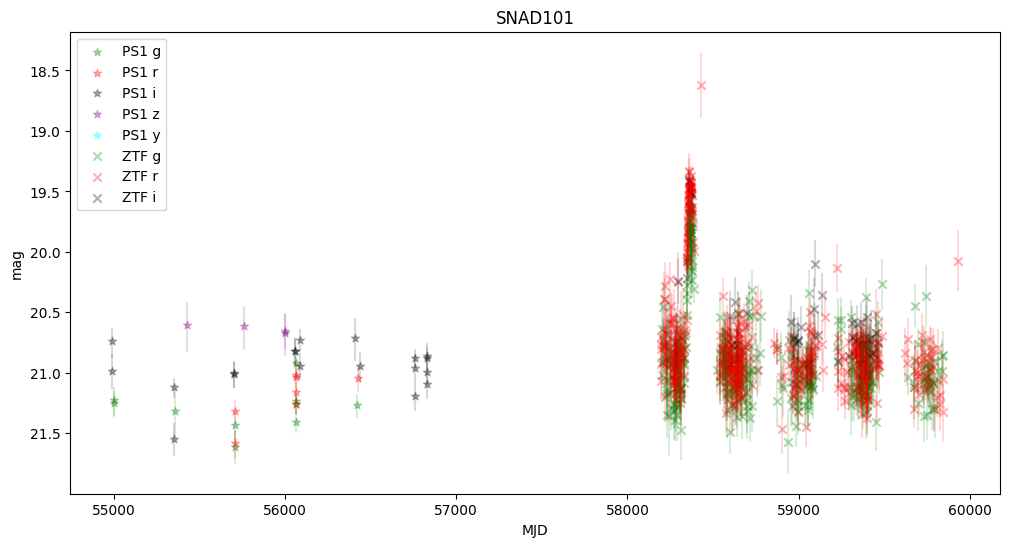

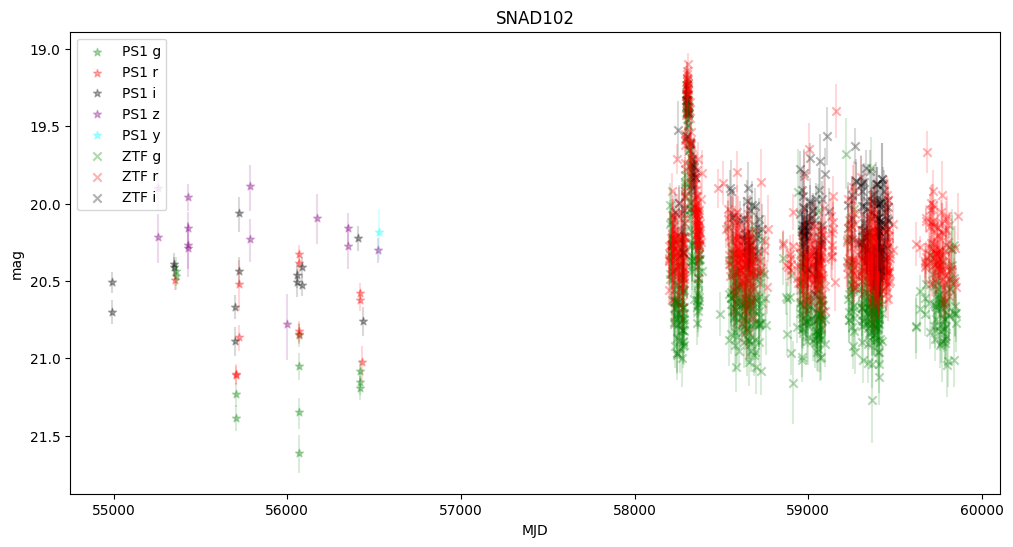

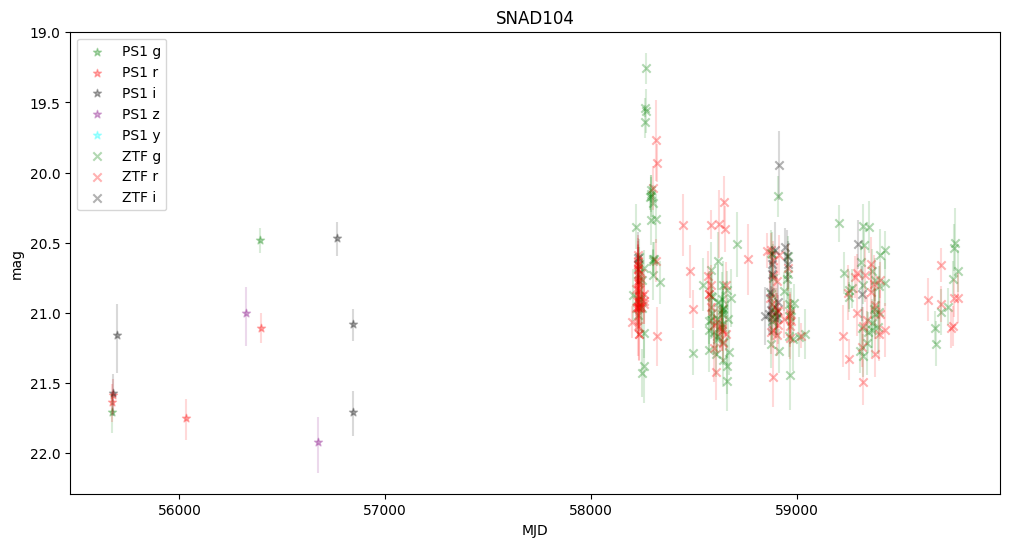

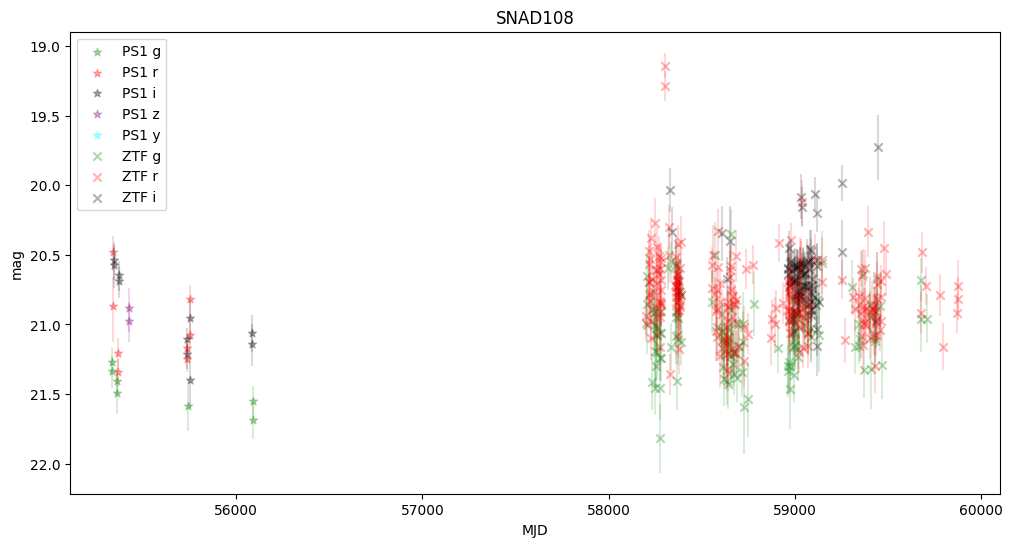

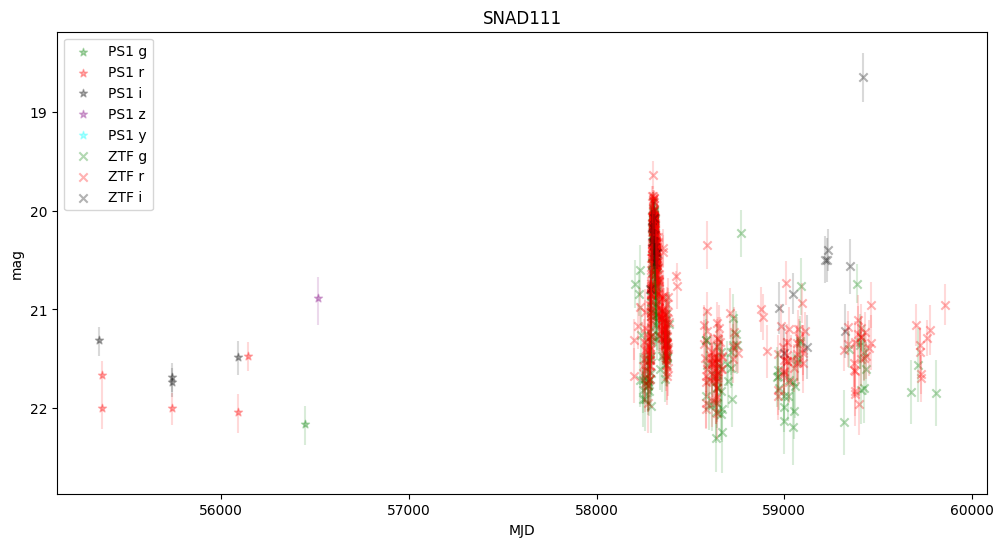

In [9]:
MAG_OR_FLUX = "mag"

ps1_filter_id_to_name = {1: "g", 2: "r", 3: "i", 4: "z", 5: "y"}
get_ps1_name_from_filter_id = np.vectorize(ps1_filter_id_to_name.get)
filter_colors = {"g": "green", "r": "red", "i": "black", "z": "purple", "y": "cyan"}

ndf_sorted = ndf.sort_values("Name")

for i in range(5):
    # snad_name is a string, ps1_lc and ztf_lc are pandas dataframes
    snad_name, ps1_lc, ztf_lc = ndf_sorted.iloc[i][["Name", "ps1_lc", "ztf_lc"]]

    # when we iterate a nested series we are getting pandas dataframes of light curves
    plt.figure(figsize=(12, 6))

    # PS1
    ps1_bands = get_ps1_name_from_filter_id(ps1_lc["filterID"])
    for band in "grizy":
        color = filter_colors[band]
        band_idx = ps1_bands == band
        t = ps1_lc["obsTime"][band_idx]
        flux = ps1_lc["psfFlux"][band_idx] * 1e6  # micro Jy
        err = ps1_lc["psfFluxErr"][band_idx] * 1e6
        mag = 8.9 - 2.5 * np.log10(flux / 1e6)
        mag_plus = 8.9 - 2.5 * np.log10((flux - err) / 1e6)
        mag_minus = 8.9 - 2.5 * np.log10((flux + err) / 1e6)
        if MAG_OR_FLUX == "flux":
            plt.scatter(
                t,
                flux,
                marker="*",
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        elif MAG_OR_FLUX == "mag":
            plt.scatter(
                t,
                mag,
                marker="*",
                color=color,
                label=f"PS1 {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                [mag - mag_minus, mag_plus - mag],
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            raise ValueError(f"MAG_OR_FLUX should be mag or flux")

    # ZTF
    ztf_bands = ztf_lc["band"]
    for band in "gri":
        band_idx = ztf_bands == band
        color = filter_colors[band]
        t = ztf_lc["mjd"][band_idx]
        mag = ztf_lc["mag"][band_idx]
        magerr = np.asarray(ztf_lc["magerr"][band_idx], dtype=float) * 1e-4
        flux = np.power(10, 0.4 * (8.9 - mag)) * 1e6  # micro Jy
        err = 0.4 * np.log(10) * flux * magerr
        if MAG_OR_FLUX == "flux":
            plt.scatter(
                t,
                flux,
                marker="x",
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                flux,
                err,
                ls="",
                color=color,
                alpha=0.15,
            )
        else:
            plt.scatter(
                t,
                mag,
                marker="x",
                color=color,
                label=f"ZTF {band}",
                alpha=0.3,
            )
            plt.errorbar(
                t,
                mag,
                magerr,
                ls="",
                color=color,
                alpha=0.15,
            )

    plt.title(snad_name)
    plt.xlabel("MJD")
    plt.ylabel("Flux, μJy" if MAG_OR_FLUX == "flux" else "mag")
    if MAG_OR_FLUX == "mag":
        plt.gca().invert_yaxis()
    plt.legend(loc="upper left")